#**Машинное обучение ИБ-2024**

#**Домашнее задание 2.**
#Классификация, KNN, LogReg, SVC.

In [1]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## **Теоретическая Часть**

Мы рассматриваем задачу бинарной классификации. Для прогнозирования мы хотели бы использовать модель логистической регрессии. Для регуляризации мы добавляем комбинацию штрафов в размере $l_2$ и $l_1$ (Elastic Net).

Каждый объект в обучающем наборе данных индексируется с помощью $i$ и описывается парой: объекты $x_i\in\mathbb{R}^{K}$ и двоичные метки $y_i$. Модель параметризуется со смещением $w_0\in\mathbb{R}$ и весами $w\in\mathbb{R}^K$.

Задача оптимизации в отношении $w_0, w$ заключается в следующем (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.



Градиенты функции потерь логистической регрессии представлены ниже:

$$dL(w, w_0)/ dw = -\frac{1}{N}  \frac{X*y^\top}{1 + \exp(y (Xw+w_0)))} + \gamma * sign(w) + 2 * beta * w$$

$$dL(w, w_0)/ dw_0 = -\frac{1}{N}  \frac{y}{1 + \exp(y*(Xw+w_0)))}$$

#### 1. [0.5 Балл] Реализуйте функцию, выдающий значение функции потерь логичтической регрессии:

In [ ]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    """
    Вычисляет значение функции потерь логистической регрессии с регуляризацией Elastic Net.

    :param X: np.ndarray формы (n_objects, n_features) -- матрица объектов-признаков
    :param y: np.ndarray формы (n_objects,) -- вектор меток (-1 или 1)
    :param w: List[float] -- веса модели
    :param w0: float -- смещение (intercept)
    :param gamma: float -- коэффициент регуляризации L1
    :param beta: float -- коэффициент регуляризации L2
    :return: float -- значение функции потерь
    """
    N = X.shape[0]
    z = y * (X @ w + w0)  # y_i (w^T x_i + w0)
    # Логистическая потеря
    loss_terms = np.log(1 + np.exp(-z))
    loss_value = np.mean(loss_terms)
    # Регуляризация
    l1 = gamma * np.sum(np.abs(w))
    l2 = beta * np.sum(w ** 2)
    return loss_value + l1 + l2


#### 2. [0.5 Балл] Реализуйте функцию, которая будет возвращать градиенты весов вашей модели Логистической регрессии:

In [2]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    """
    Вычисляет градиенты функции потерь по весам и смещению.

    :param X: np.ndarray формы (n_objects, n_features) -- матрица объектов-признаков
    :param y: np.ndarray формы (n_objects,) -- вектор меток (-1 или 1)
    :param w: List[float] -- веса модели
    :param w0: float -- смещение (intercept)
    :param gamma: float -- коэффициент регуляризации L1
    :param beta: float -- коэффициент регуляризации L2
    :return: Tuple[List[float], float] -- градиенты по весам и смещению
    """
    N, K = X.shape
    z = y * (X @ w + w0)  # y_i (w^T x_i + w0)
    # Сигмоидная функция для вычисления вероятностей
    sigmoid = 1 / (1 + np.exp(z))
    # Градиент по весам
    grad_w = (-1 / N) * (X.T @ (y * sigmoid)) + gamma * np.sign(w) + 2 * beta * w
    # Градиент по смещению
    grad_w0 = (-1 / N) * np.sum(y * sigmoid)
    return grad_w.tolist(), grad_w0


In [3]:
# код для проверки

np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844,
                   rtol=1e-2)
)

####  3. [1 Балл]  Реализуйте класс для модели логистической регрессии, используя выше написанные функции:

Модель должна обучаться методом SGD.

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve
import numpy as np

class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42):
        """
        Инициализация модели логистической регрессии.

        :param beta: float -- коэффициент регуляризации L2
        :param gamma: float -- коэффициент регуляризации L1
        :param lr: float -- скорость обучения
        :param tolerance: float -- критерий остановки по изменению функции потерь
        :param max_iter: int -- максимальное количество итераций
        :param random_state: int -- фиксируем генератор случайных чисел
        """
        self.beta = beta
        self.gamma = gamma
        self.lr = lr
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_state = random_state
        self.w = None
        self.w0 = None
        self.loss_history = []

    def fit(self, X, y):
        """
        Обучение модели методом стохастического градиентного спуска (SGD).

        :param X: np.ndarray формы (n_objects, n_features) -- матрица объектов-признаков
        :param y: np.ndarray формы (n_objects,) -- вектор меток (-1 или 1)
        :return: self
        """
        np.random.seed(self.random_state)
        N, K = X.shape
        self.w = np.zeros(K)
        self.w0 = 0.0

        for iteration in range(self.max_iter):
            # Вычисление функции потерь
            current_loss = loss(X, y, self.w, self.w0, self.gamma, self.beta)
            self.loss_history.append(current_loss)

            # Случайная выборка для SGD
            idx = np.random.randint(0, N)
            X_i = X[idx]
            y_i = y[idx]

            z_i = y_i * (np.dot(self.w, X_i) + self.w0)
            sigmoid_i = 1 / (1 + np.exp(z_i))

            # Градиенты для одного примера
            grad_w = (-y_i * X_i * sigmoid_i) + self.gamma * np.sign(self.w) + 2 * self.beta * self.w
            grad_w0 = -y_i * sigmoid_i

            # Обновление весов и смещения
            self.w -= self.lr * grad_w
            self.w0 -= self.lr * grad_w0

            # Проверка условия сходимости
            if iteration > 0 and abs(self.loss_history[-2] - self.loss_history[-1]) < self.tolerance:
                print(f'Сходимость достигнута на итерации {iteration}')
                break

        return self

    def predict_proba(self, X):
        """
        Оценка вероятностей принадлежности к классу 1.

        :param X: np.ndarray формы (n_objects, n_features)
        :return: np.ndarray формы (n_objects, 2) -- вероятности для каждого класса
        """
        z = X @ self.w + self.w0
        proba = 1 / (1 + np.exp(-z))
        return np.vstack([1 - proba, proba]).T

    def predict(self, X):
        """
        Предсказание классов для объектов из X.

        :param X: np.ndarray формы (n_objects, n_features)
        :return: np.ndarray формы (n_objects,) -- предсказанные метки
        """
        proba = self.predict_proba(X)[:, 1]
        return np.where(proba >= 0.5, 1, -1)


In [ ]:
# этот код менять не надо!
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

####  4. [0.5 Балл]  Реализуйте функцию, которая отрисовывает объекты вашего датасета, их метки и разделяющую гиперплоскость, полученную от Логистической регрессии (пример того, что должно получиться ниже):

In [ ]:
def plot_decision_boundary(model, X, y):
    """
    Отрисовка объектов, их меток и разделяющей гиперплоскости модели логистической регрессии.

    :param model: обученная модель (например, Logit)
    :param X: np.ndarray формы (n_objects, 2) -- матрица объектов-признаков
    :param y: np.ndarray формы (n_objects,) -- вектор меток (-1 или 1)
    """
    # Определение границ графика
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.01  # шаг сетки

    # Создание сетки для отрисовки
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = model.predict_proba(grid)[:, 1].reshape(xx.shape)

    # Отрисовка контуров
    plt.contourf(xx, yy, probs, levels=[0, 0.5, 1], alpha=0.2, colors=['blue', 'red'])

    # Отрисовка точек
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolor='k')

    # Отображение границы принятия решения
    plt.contour(xx, yy, probs, levels=[0.5], colors='k')

    plt.xlabel('Признак 1')
    plt.ylabel('Признак 2')
    plt.title('Разделяющая гиперплоскость логистической регрессии')
    plt.show()


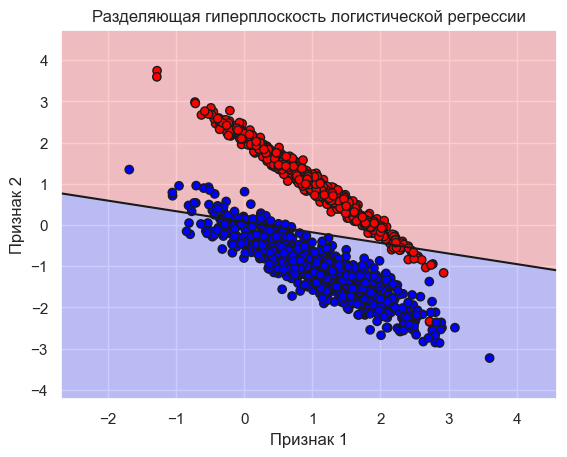

In [ ]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.5 Балл] Для предыдущей задачи отобразите на графике, как изменяется значение функция потерь от номера итерации.

In [ ]:
def plot_loss_history(model):
    """
    Отображает, как изменяется значение функции потерь от номера итерации.

    :param model: обученная модель (например, Logit)
    """
    plt.figure(figsize=(8, 6))
    plt.plot(model.loss_history, label='Функция потерь')
    plt.xlabel('Итерация')
    plt.ylabel('Значение функции потерь')
    plt.title('История функции потерь')
    plt.legend()
    plt.grid(True)
    plt.show()


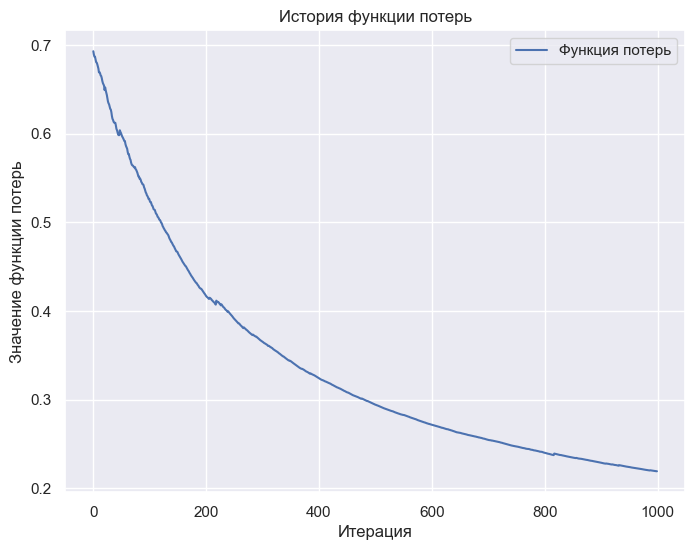

In [ ]:
plot_loss_history(model)

#### 6. [2 Балл] Для данных, на которых тестировали модель Логистической регрессии, заиспользуйте модель SVC из библиотеки sklearn. Попробуйте различные ядра (kernel) и различные коэфициенты C. Посмотрите на метрики, которые мы обсуждали на занятии (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import GridSearchCV

# Подготовка данных (используем те же X и y, что и ранее)
model_svc = SVC(probability=True, random_state=42)

# Определение параметров для сеточного поиска
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Инициализация GridSearchCV
grid_search = GridSearchCV(model_svc, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Обучение модели
grid_search.fit(X, y)

# Вывод лучших параметров
print("Лучшие параметры SVC:", grid_search.best_params_)

# Оценка на тестовых данных (предполагаем, что есть разделение на train/test)
# Для примера используем те же данные
y_pred = grid_search.predict(X)
y_proba = grid_search.predict_proba(X)[:, 1]

# Вычисление метрик
acc = accuracy_score(y, y_pred)
prec = precision_score(y, y_pred, pos_label=1)
rec = recall_score(y, y_pred, pos_label=1)
auc = roc_auc_score(y, y_proba)
f1 = f1_score(y, y_pred, pos_label=1)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"AUC-ROC: {auc:.4f}")
print(f"F1-Score: {f1:.4f}")


Лучшие параметры SVC: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.9961
Precision: 0.9956
Recall: 0.9967
AUC-ROC: 0.9974
F1-Score: 0.9961


#### 7. [2 Балл] Реализуйте класс KNNClassifier, который должен реализовывать классификацию путем нахождения k ближайших соседей. В методе predict_proba Вам необходимо выдавать вектор вероятностей для каждого объекта, который означает, что объект является экземпляром i-го класса с p_i вероятностью. Протестируйте Ваш класс на данных, сгенерированных выше, посмотрите на метрики (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.stats import mode

class KNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors=5, metric='euclidean'):
        """
        Инициализация KNN классификатора.

        :param n_neighbors: int -- количество соседей
        :param metric: str -- метрика расстояния
        """
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        """
        Запоминает обучающие данные.

        :param X: np.ndarray формы (n_objects, n_features)
        :param y: np.ndarray формы (n_objects,)
        :return: self
        """
        self.X_train = X
        self.y_train = y
        return self

    def predict(self, X):
        """
        Предсказывает классы для объектов из X.

        :param X: np.ndarray формы (n_objects, n_features)
        :return: np.ndarray формы (n_objects,) -- предсказанные метки
        """
        from sklearn.metrics import pairwise_distances
        distances = pairwise_distances(X, self.X_train, metric=self.metric)
        nearest_indices = np.argsort(distances, axis=1)[:, :self.n_neighbors]
        nearest_labels = self.y_train[nearest_indices]
        majority_votes, _ = mode(nearest_labels, axis=1)
        return majority_votes.flatten()

    def predict_proba(self, X):
        """
        Вычисляет вероятности принадлежности к классам.

        :param X: np.ndarray формы (n_objects, n_features)
        :return: np.ndarray формы (n_objects, n_classes) -- вероятности для каждого класса
        """
        from sklearn.metrics import pairwise_distances
        distances = pairwise_distances(X, self.X_train, metric=self.metric)
        nearest_indices = np.argsort(distances, axis=1)[:, :self.n_neighbors]
        nearest_labels = self.y_train[nearest_indices]

        # Определяем уникальные классы и их количество
        classes = np.unique(self.y_train)
        n_classes = len(classes)

        proba = []
        for labels in nearest_labels:
            counts = np.bincount(labels, minlength=n_classes)
            proba.append(counts / self.n_neighbors)
        return np.array(proba)


Тестирование KNNClassifier и вычисление метрик

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

# Преобразуем метки классов из -1 и 1 в 0 и 1
y_transformed = np.where(y == -1, 0, 1)

# Инициализация и обучение модели
knn = KNNClassifier(n_neighbors=3, metric='euclidean')
knn.fit(X, y_transformed)

# Предсказания
y_pred_knn = knn.predict(X)
y_proba_knn = knn.predict_proba(X)[:, 1]  # Вероятность принадлежности к классу 1

# Проверка, что вероятности находятся в диапазоне [0, 1]
if np.any(y_proba_knn < 0) or np.any(y_proba_knn > 1):
    raise ValueError("Вероятности должны быть в диапазоне [0, 1]")

# Вычисление метрик
acc_knn = accuracy_score(y_transformed, y_pred_knn)
prec_knn = precision_score(y_transformed, y_pred_knn, pos_label=1)
rec_knn = recall_score(y_transformed, y_pred_knn, pos_label=1)
auc_knn = roc_auc_score(y_transformed, y_proba_knn)
f1_knn = f1_score(y_transformed, y_pred_knn, pos_label=1)

print(f"KNN Accuracy: {acc_knn:.4f}")
print(f"KNN Precision: {prec_knn:.4f}")
print(f"KNN Recall: {rec_knn:.4f}")
print(f"KNN AUC-ROC: {auc_knn:.4f}")
print(f"KNN F1-Score: {f1_knn:.4f}")

/var/folders/jl/cjrfbx7n14g8kdszsn8y_st40000gn/T/ipykernel_66763/2205577576.py:40: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  majority_votes, _ = mode(nearest_labels, axis=1)


KNN Accuracy: 0.9956
KNN Precision: 0.9945
KNN Recall: 0.9967
KNN AUC-ROC: 1.0000
KNN F1-Score: 0.9956


## **Практическая часть**

В этом задании мы будем работать с Датасетом Fashion Mnist. Это датасет, который представляет изображения одного канала с различными типами одежды. Вам необходимо провести полный пайплайн обучения моделей (KNN и Logreg), которые вы можете импортировать из библиотеки sklearn.

#### 8. [0 Балл] Импортируйте датафрейм из csv файла. Поделите выборку следующим образом - :50000 (Train) и 50000: (Test).

#### 9. [0.5 Балл] Визуализируйте некоторые из объектов датасета. В колонках отображены яркости пикселей, которые представляют из себя изображения Fashion Mnist. С помощью matplotlib визуализируйте по одному представителю каждого класса.

#### 10. [0.5 Балл] Отнормируйте признаки в датасете, попробуйте два варианта StandartScaller и MinMaxScaller.

#### 10. [2 Балл] Проведите эксперименты: для моделей KNeighborsClassifier и LogisticRegression подберите гиперпараметры с помощью GridSerchCV (минимум 5 фолдов). Получите качество моделей на тестовой выборке. Основная метрика в данном задании будет accuracy. Сравните эти две модели. Какая модель показывает лучшее качество, предположите почему и напишите ответ.

**NB!**: в задании нужно подбирать несколько гиперпараметров по сетке. Какие гиперпараметры подбирать - решаете Вы сами. Обязательно обоснуйте, почему и какие параметры Вы подбираете! Например, подбор только гиперпараметра C в LogisticRegression не будет засчитываться как решение данного задания! Попытайтесь серьезно отнестись к нему, будто вы за это получите зарплату 300к.

## **Бонусы**

#### Задача 1. [1 Балл] У Вас есть датасет с 10**4 объектами. У всех объектов два признака и все они одинаковые у всех объектов. Однако, 5000 - отрицательного класса и 5000 - положительного класса. Вы запускате Логистическую регрессию для классификации на данном датасете. Что Вы получите в итоге обучения данной модели на SGD? Ответ обоснуйте.

#### Задача 2. [1 Балл] При классификации Fashion Mnist модель Логистической регрессии на обучении многоклассовой классификации методом One-VS-All у Вас получилось k классификаторов. Изобразите веса ваших полученных моделей как изображения в matplotlib. Возможно, модель выучила какие-то графические паттерны в данных? Ответ обоснуйте.

#### Задача 3. [1 Балл] В задаче классификации Fashion Mnist Вы попытались выбить какой-то accuracy. Для получения бонусного балла Вам нужно на той же самой выборке получить значение метрики accuracy > 0.87 на тесте (Тестовую выборку менять нельзя, но обучающую можно). Какими моделями и методами Вы это будете делать - на Ваше усмотрение, но **нельзя использовать никакие нейронные сети**. Необходимо получить модель машинного обучения, выполняющую эту задачу.